# Drive設置

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 定義訓練流程之通用函數

## 載入套件

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.callbacks import ModelCheckpoint

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [18]:
# use the model you want
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

## 定義Dataloader

In [19]:
def get_dataloader(train_dir, preprocess_input=None, img_size=(224, 224), batch_size=32):

  # 定義dataloader，使用資料增強（Data Augmentation）
  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,  # 隨機錯切
      zoom_range=0.2,   # 隨機縮放
      horizontal_flip=True,  # 水平翻轉
      rotation_range=20,  # 隨機旋轉
      fill_mode='nearest',  # 填補模式
      validation_split=0.2
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical', # categorical
      subset='training'
  )

  val_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',
      subset='validation'
  )

  return train_generator, val_generator


## 重製分類頭並建立模型

| 模型             | 特徵圖輸出形狀 (before GAP) | GAP後形狀 (Dense輸入) |
| -------------- | -------------------- | ---------------- |
| VGG19          | (7, 7, 512)          | (512,)           |
| ResNet50       | (7, 7, 2048)         | (2048,)          |
| EfficientNetB0 | (7, 7, 1280)         | (1280,)          |


In [20]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers

def replace_classification_head(old_model, num_classes):
    """
    從已訓練模型載入，去除分類頭，並重新建立相同架構的新分類頭。

    傳入：
        old_model: 儲存為 .keras 的舊模型（含分類頭）
        num_classes: 新任務的分類數

    回傳：
        model: 去除舊分類頭並加上新分類頭的模型
    """
    activation = 'softmax' if num_classes > 1 else 'sigmoid'

    # 根據 summary 找到去除分類頭的最後一層（通常是倒數第3或第4層）
    # 假設原本分類頭前是 GlobalAveragePooling2D，我們保留這層的輸出
    # 若你原本是直接接 Dense，請修改下方 get_layer 名稱
    feature_layer = old_model.get_layer("global_average_pooling2d")

    x = feature_layer.output
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output_tensor = layers.Dense(num_classes, activation=activation)(x)

    # 建立新模型
    new_model = Model(inputs=old_model.input, outputs=output_tensor)
    return new_model


## callback tools

In [21]:
import pickle
import os

class HistorySaver(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

In [22]:
from keras.callbacks import ReduceLROnPlateau
'''
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)
'''

"\nlr_scheduler = ReduceLROnPlateau(\n    monitor='val_loss',\n    factor=0.5,\n    patience=2,\n    min_lr=1e-7,\n    verbose=1\n)\n"

## 定義訓練函數

In [23]:
def train_model_with_gpu_check(model, train_generator, val_generator, lr, epochs, save_dir, phase, lr_scheduler=None):
    """
    檢查 GPU 可用性並訓練模型，儲存最佳模型。

    參數：
        model: 已經編譯好的模型。
        train_generator: 訓練數據生成器（如 ImageDataGenerator 生成器）。
        val_generator: 驗證數據生成器（如 ImageDataGenerator 生成器）。
        epochs: 訓練的輪數（預設為 5）。
        save_dir: 儲存模型的資料夾（預設為 'models'）。
        phase: 訓練階段（'phase1' 或 'phase2'）

    回傳：
        history: 訓練過程的歷史紀錄。
    """

    # 檢查是否有可用的 GPU
    gpus = tf.config.list_physical_devices('GPU')
    #if len(gpus) == 0:
        #raise Exception("No GPU available, stop traing process")
    print("Num GPUs Available: ", len(gpus))

    #loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    loss = 'categorical_crossentropy'
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])

    # 設定儲存中間資訊
    checkpoint = ModelCheckpoint(os.path.join(save_dir, phase + '_best_model.keras'), monitor='val_loss', save_best_only=True)
    history_saver = HistorySaver(os.path.join(save_dir, phase + '_history.pkl'))

    # 預設 learning rate scheduler
    callbacks = [checkpoint, history_saver]
    if lr_scheduler is not None:
        callbacks.append(lr_scheduler)

    # 訓練模型
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

## 視覺化呈現

In [24]:
def plot_learning_curve_with_split(history, save_dir, phase):
    """
    根據 keras 的 history 物件繪製並儲存學習曲線。
    儲存三張圖：合併版、acc 單獨圖、loss 單獨圖。

    參數：
        history: keras.callbacks.History（model.fit() 的回傳結果）
        save_dir: 儲存圖像的資料夾（預設為 'output'）
    """
    os.makedirs(save_dir, exist_ok=True)

    # 1. 合併版
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, phase + '_learning_curve.png'))
    plt.show()

    # 2. Accuracy 單獨
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))
    plt.savefig(os.path.join(save_dir, phase + '_accuracy_curve.png'))
    #plt.show()

    # 3. Loss 單獨
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))
    plt.savefig(os.path.join(save_dir, phase + '_loss_curve.png'))
    #plt.show()


## 保存模型

In [25]:
import os

def save_model(model, save_dir, filename):
    """
    儲存 Keras 模型為指定格式（支援 .keras 或 .h5）

    參數：
        model: 已訓練的 Keras 模型
        filename: 儲存檔名（預設為 'model.keras'）
        save_dir: 儲存資料夾（預設為 'models'）
    """
    os.makedirs(save_dir, exist_ok=True)
    full_path = os.path.join(save_dir, filename)
    model.save(full_path)
    print(f"✅ 模型已儲存至 {full_path}")


# 定義測試流程之通用函數

## 載入套件

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import cv2
import os

## acc, loss

In [3]:
def evaluate_model(model, test_generator):
    loss, acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Loss: {loss:.4f}")
    return acc, loss

## confusion matrix

In [4]:
def plot_confusion_matrix(model, test_generator, class_names, save_dir):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
    plt.show()

    print(classification_report(y_true, y_pred_classes, target_names=class_names))


## misclassifications sample

In [5]:

def analyze_misclassifications(model, test_generator, class_names, num_samples=5):
    # 取得真實標籤與預測結果
    y_true = test_generator.classes
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # 找出預測錯誤的索引
    wrong_idxs = np.where(y_pred_classes != y_true)[0]
    print(f"Found {len(wrong_idxs)} misclassified samples.")

    # 顯示前 num_samples 筆錯誤樣本
    for idx in wrong_idxs[:num_samples]:
        img_path = test_generator.filepaths[idx]
        true_class = class_names[y_true[idx]]
        pred_class = class_names[y_pred_classes[idx]]

        # 載入原始圖片（注意 test_generator 是 flow_from_directory 的）
        img = cv2.imread(img_path)  # BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉為 RGB 給 matplotlib 用

        plt.imshow(img)
        plt.title(f"True: {true_class}, Pred: {pred_class}")
        plt.axis('off')
        plt.show()


## grad cam

In [6]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00


In [7]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def deprocess_image(img_tensor):
    """
    將 preprocess_input() 處理過的影像還原回 [0, 1] RGB 範圍，用於顯示。
    """
    img = img_tensor.copy()
    # 針對 ResNet / VGG 系列的預處理進行還原
    img += [103.939, 116.779, 123.68]  # BGR -> RGB
    img = img[..., ::-1]  # BGR to RGB
    img = np.clip(img / 255.0, 0, 1)  # normalize
    return img

def visualize_gradcam_with_vis(model, test_generator, class_names, layer_name='conv5_block3_out', num_samples=3):
    test_generator.reset()

    gradcam = Gradcam(model,
                      model_modifier=ReplaceToLinear(),
                      clone=True)

    for i in range(num_samples):
        img_batch, label = test_generator[i]
        img = img_batch[0:1]
        true_class_index = np.argmax(label[0])
        pred = model.predict(img)
        pred_class = np.argmax(pred[0])

        score = CategoricalScore([pred_class])
        cam = gradcam(score, img, penultimate_layer=layer_name)
        heatmap = cam[0]

        # 還原預處理圖像以正確顯示
        restored_img = deprocess_image(img[0])

        plt.figure()
        plt.imshow(restored_img)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        title = f"Grad-CAM: Actual={class_names[true_class_index]} ,Pred={class_names[pred_class]}" if class_names else f"Class {pred_class}"
        plt.title(title)
        plt.axis('off')
        plt.show()


In [8]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def deprocess_image(img_tensor):
    """
    將 preprocess_input() 處理過的影像還原回 [0, 1] RGB 範圍，用於顯示。
    """
    img = img_tensor.copy()
    img += [103.939, 116.779, 123.68]  # BGR mean
    img = img[..., ::-1]  # BGR to RGB
    img = np.clip(img / 255.0, 0, 1)
    return img

def visualize_gradcam_each_class(model, test_generator, class_names, layer_name='conv5_block3_out'):
    test_generator.reset()
    gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)

    collected_classes = set()
    total_classes = len(test_generator.class_indices)

    for batch_img, batch_label in test_generator:
        for i in range(len(batch_img)):
            img = batch_img[i:i+1]
            true_class = np.argmax(batch_label[i])
            if true_class in collected_classes:
                continue

            # 預測與 Grad-CAM
            pred = model.predict(img)
            pred_class = np.argmax(pred[0])
            score = CategoricalScore([pred_class])
            cam = gradcam(score, img, penultimate_layer=layer_name)
            heatmap = cam[0]

            # 顯示圖像
            restored_img = deprocess_image(img[0])
            plt.figure()
            plt.imshow(restored_img)
            plt.imshow(heatmap, cmap='jet', alpha=0.5)
            title = f"Class {true_class} → Pred: {pred_class}" if not class_names else f"{class_names[true_class]} → {class_names[pred_class]}"
            plt.title(title)
            plt.axis('off')
            plt.show()

            collected_classes.add(true_class)
            if len(collected_classes) == total_classes:
                return


# 測試自建資料集

## 轉換資料格式

In [9]:
!pip install pillow pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00


In [10]:
import os
from PIL import Image
import pillow_heif

# 原始 HEIC 圖片資料夾
input_root = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/test_data"
# 輸出 JPG 資料夾
output_root = 'converted_data'

# 建立輸出資料夾
os.makedirs(output_root, exist_ok=True)

# 遍歷所有子資料夾與檔案
for root, dirs, files in os.walk(input_root):
    for file in files:
        if file.lower().endswith('.heic'):
            input_path = os.path.join(root, file)

            # 建立對應的輸出資料夾結構
            relative_path = os.path.relpath(root, input_root)
            output_dir = os.path.join(output_root, relative_path)
            os.makedirs(output_dir, exist_ok=True)

            # 轉換為 JPG 並儲存
            try:
                heif_file = pillow_heif.read_heif(input_path)
                image = Image.frombytes(
                    heif_file.mode, heif_file.size, heif_file.data, "raw"
                )
                output_filename = os.path.splitext(file)[0] + '.jpg'
                output_path = os.path.join(output_dir, output_filename)
                image.save(output_path, format="JPEG")
                print(f"✔ 轉換成功: {input_path} → {output_path}")
            except Exception as e:
                print(f"✘ 無法轉換 {input_path}: {e}")


✔ 轉換成功: /content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/test_data/anger/IMG_2554.HEIC → converted_data/anger/IMG_2554.jpg
✔ 轉換成功: /content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/test_data/anger/IMG_2544.HEIC → converted_data/anger/IMG_2544.jpg
✔ 轉換成功: /content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/test_data/anger/IMG_2542.HEIC → converted_data/anger/IMG_2542.jpg
✔ 轉換成功: /content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/test_data/anger/IMG_2543.HEIC → converted_data/anger/IMG_2543.jpg
✔ 轉換成功: /content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/test_data/contempt/IMG_2559.HEIC → converted_data/contempt/IMG_2559.jpg
✔ 轉換成功: /content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/test_data/contempt/IMG_2550.HEIC → converted_data/contempt/IMG_2550.jpg
✔ 轉換成功: /content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/test_data/contempt/IMG_2546.HEIC → converted_data/contempt/IMG_2546.jpg
✔ 轉換成功: /content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/test_data/disgust/IMG_2561.HEIC → conver

## 定義Dataloader

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

def get_self_trainloader(train_dir, img_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=5,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator

def get_self_testloader(test_dir, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator


## 訓練前測試

Found 21 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.3333 - loss: 7.9682
Test Accuracy: 0.3333
Test Loss: 7.9682
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


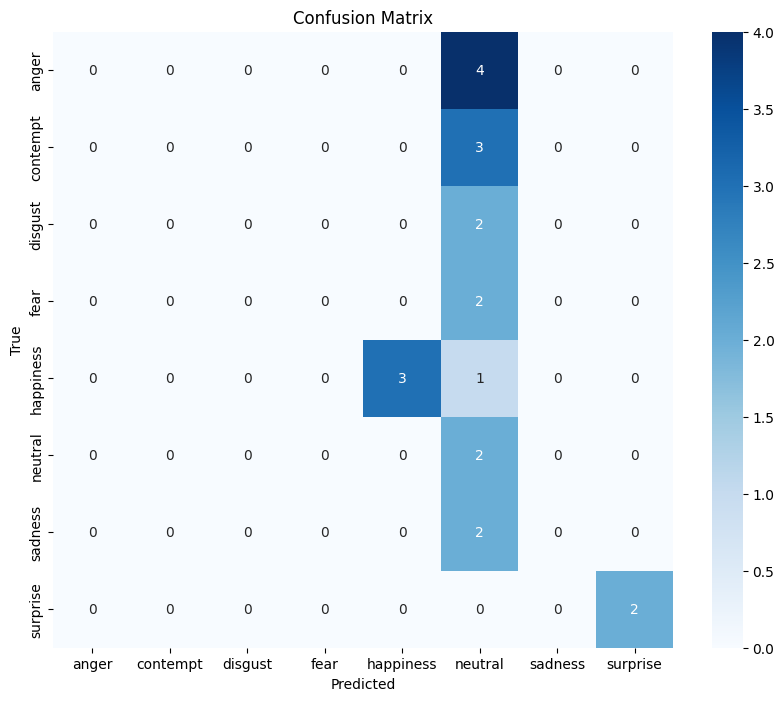

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         4
    contempt       0.00      0.00      0.00         3
     disgust       0.00      0.00      0.00         2
        fear       0.00      0.00      0.00         2
   happiness       1.00      0.75      0.86         4
     neutral       0.12      1.00      0.22         2
     sadness       0.00      0.00      0.00         2
    surprise       1.00      1.00      1.00         2

    accuracy                           0.33        21
   macro avg       0.27      0.34      0.26        21
weighted avg       0.30      0.33      0.28        21



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
test_dir = '/content/converted_data'
num_classes = 8
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test"
model_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FERplus"

model = models.load_model(os.path.join(model_dir, "phase3_best_model.keras"), compile=False)
model.trainable = False
for layer in model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 測試與分析
test_generator = get_self_testloader(test_dir)
class_names = list(test_generator.class_indices.keys())
evaluate_model(model, test_generator)
plot_confusion_matrix(model, test_generator, class_names, save_dir)

## 訓練

In [36]:
# 載入在FER+訓練的EfficientNetB0模型
train_dir = '/content/converted_data'
num_classes = 8
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/VGG19"

Found 21 images belonging to 8 classes.
Found 21 images belonging to 8 classes.
Num GPUs Available:  0
Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1485 - loss: 12.2489 - val_accuracy: 0.3333 - val_loss: 8.6972
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4187 - loss: 7.9359 - val_accuracy: 0.2857 - val_loss: 8.3646
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2428 - loss: 10.5131 - val_accuracy: 0.3810 - val_loss: 7.3031
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3970 - loss: 6.1158 - val_accuracy: 0.2857 - val_loss: 6.9845
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5391 - loss: 4.6720 - val_accuracy: 0.3333 - val_loss: 6.2308


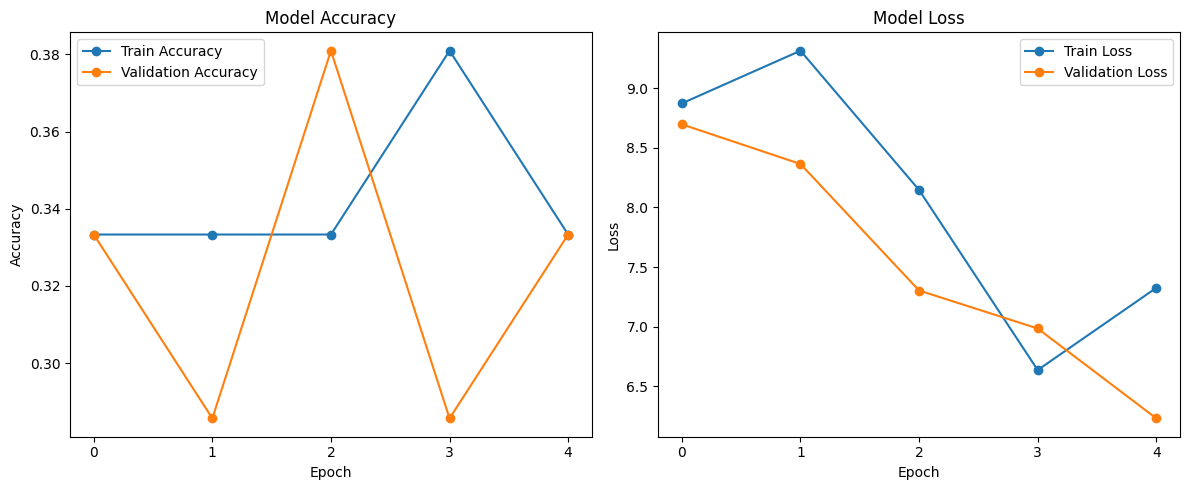

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/VGG19/VGG19_self_phase1.keras


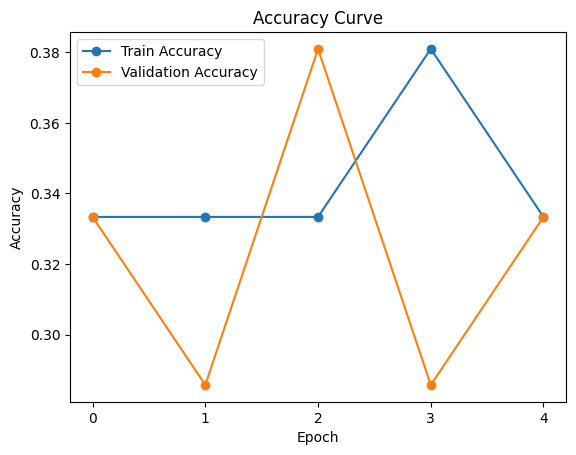

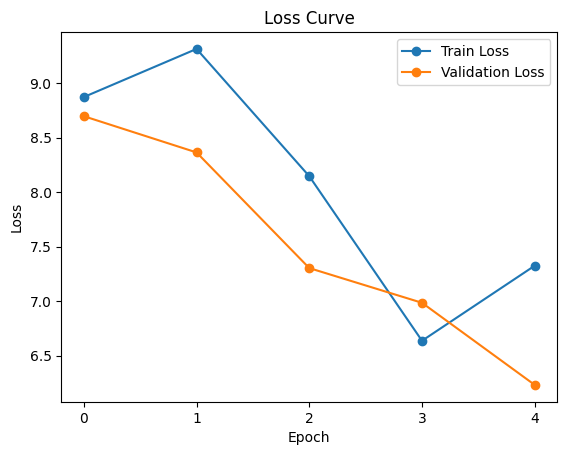

In [37]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 1
phase = 'phase1'

model = models.load_model("/content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FERplus/phase3_best_model.keras", compile=False)

model.trainable = True  # 凍結卷積層
for layer in model.layers[:22]: # 22 | global_average_pooling2d_1
    layer.trainable = False
for layer in model.layers[22:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds = get_self_trainloader(train_dir, batch_size=batch_size)
val_ds = get_self_trainloader(train_dir, batch_size=batch_size)

history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "VGG19_self_" + phase + ".keras")

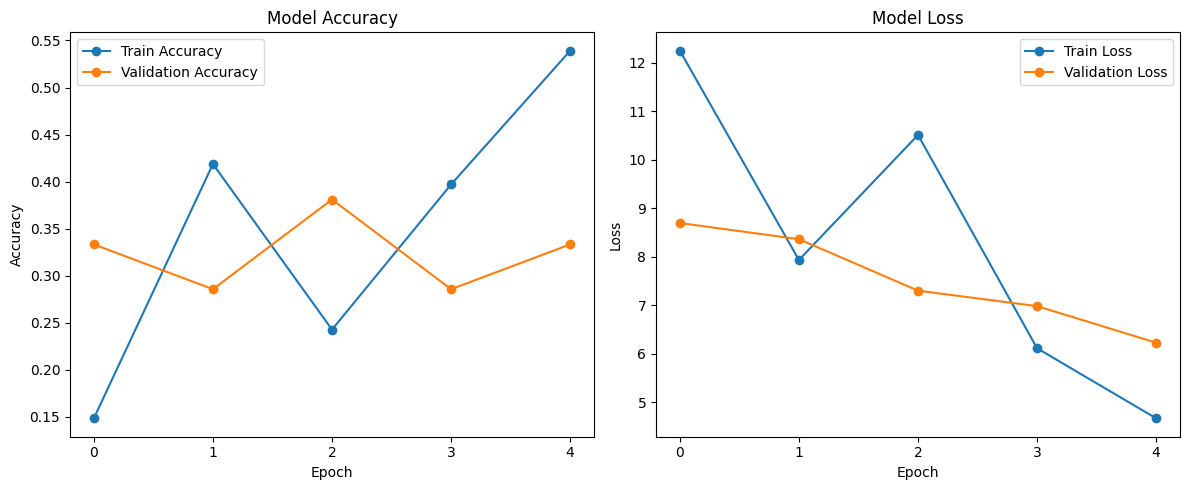

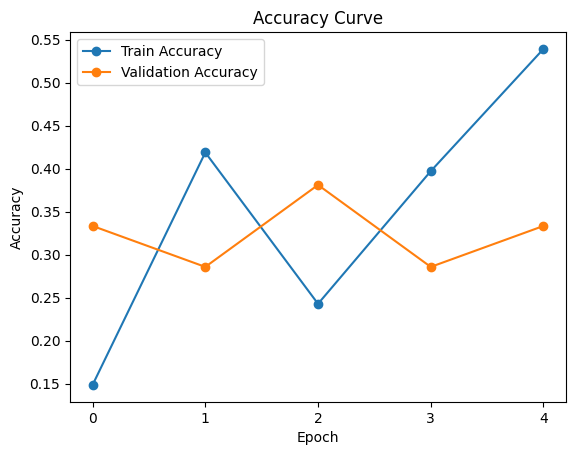

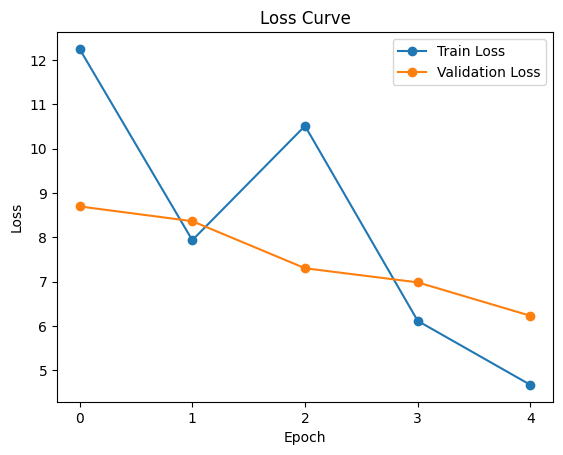

In [43]:
from tensorflow.keras.callbacks import History

# 手動重建的歷史紀錄
manual_history = {
    'accuracy':     [0.1485, 0.4187, 0.2428, 0.3970, 0.5391],
    'loss':         [12.2489, 7.9359, 10.5131, 6.1158, 4.6720],
    'val_accuracy': [0.3333, 0.2857, 0.3810, 0.2857, 0.3333],
    'val_loss':     [8.6972, 8.3646, 7.3031, 6.9845, 6.2308]
}

# 若你需要仿造一個 History 物件（非必要，依實際需求）
class ManualHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history = ManualHistory(manual_history)
plot_learning_curve_with_split(history, save_dir, phase)

## 測試

Found 21 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.3810 - loss: 6.7512
Test Accuracy: 0.3810
Test Loss: 6.7512
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


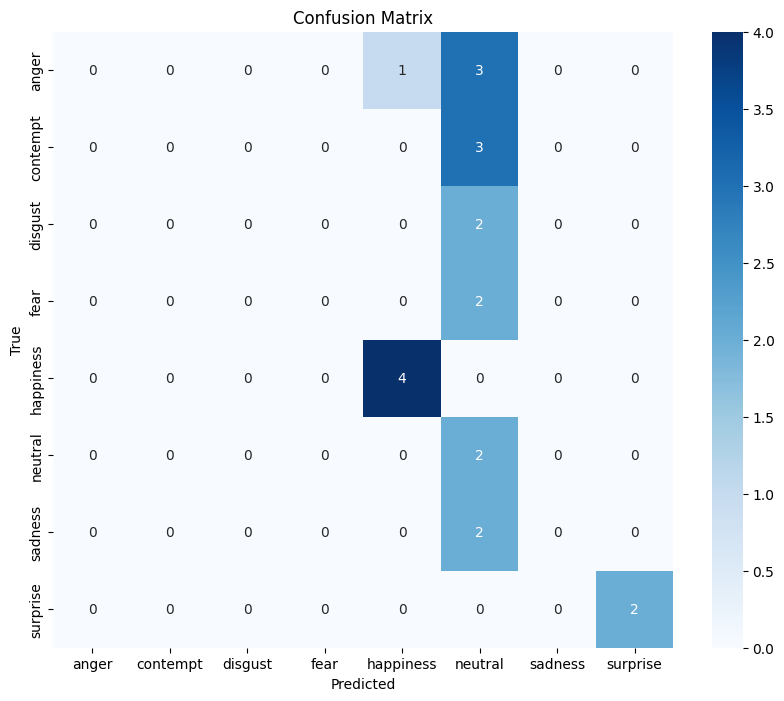

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         4
    contempt       0.00      0.00      0.00         3
     disgust       0.00      0.00      0.00         2
        fear       0.00      0.00      0.00         2
   happiness       0.80      1.00      0.89         4
     neutral       0.14      1.00      0.25         2
     sadness       0.00      0.00      0.00         2
    surprise       1.00      1.00      1.00         2

    accuracy                           0.38        21
   macro avg       0.24      0.38      0.27        21
weighted avg       0.26      0.38      0.29        21



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
test_dir = '/content/converted_data'
num_classes = 8
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test"
model_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/self_test/VGG19"

model = models.load_model(os.path.join(model_dir, "VGG19_self_phase1.keras"), compile=False)
model.trainable = False
for layer in model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 測試與分析
test_generator = get_self_testloader(test_dir)
class_names = list(test_generator.class_indices.keys())
evaluate_model(model, test_generator)
plot_confusion_matrix(model, test_generator, class_names, save_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


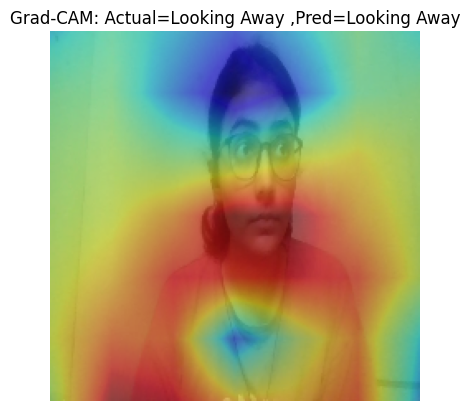

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


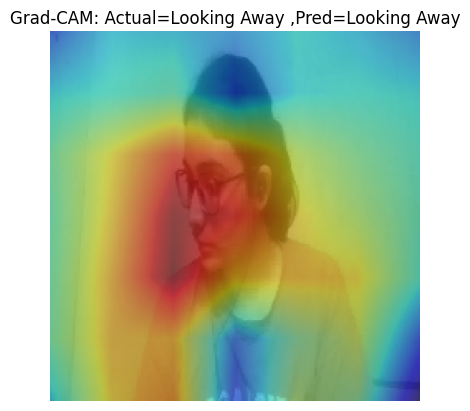

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


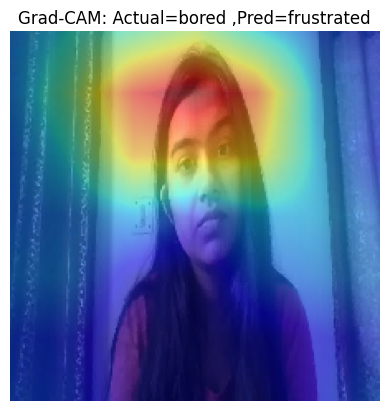

In [ ]:
visualize_gradcam_with_vis(model, test_generator, class_names, layer_name='top_conv', num_samples=3)

# 新增區段

In [14]:
from tensorflow.keras import models
model = models.load_model("/content/drive/MyDrive/中興_人工智慧概論/HW_final/VGG19/FERplus/phase3_best_model.keras", compile=False)

for i, layer in enumerate(model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

  0 | input_layer_1                            | trainable = True
  1 | block1_conv1                             | trainable = False
  2 | block1_conv2                             | trainable = False
  3 | block1_pool                              | trainable = False
  4 | block2_conv1                             | trainable = False
  5 | block2_conv2                             | trainable = False
  6 | block2_pool                              | trainable = False
  7 | block3_conv1                             | trainable = True
  8 | block3_conv2                             | trainable = True
  9 | block3_conv3                             | trainable = True
 10 | block3_conv4                             | trainable = True
 11 | block3_pool                              | trainable = True
 12 | block4_conv1                             | trainable = True
 13 | block4_conv2                             | trainable = True
 14 | block4_conv3                             | trainable = True
 15 